# PyStan: Golf case study

Source: https://mc-stan.org/users/documentation/case-studies/golf.html

In [211]:
import pystan
import numpy as np
import pandas as pd
from scipy.stats import norm

import requests 
from lxml import html
from io import StringIO

from matplotlib import pyplot as plt

Aux functions for visualization

In [228]:
def stanplot_postetior_hist(stan_sample, params):
    '''This function takes a PyStan posterior sample object and a touple of parameter names, and plots posterior dist histogram of named parameter'''
    post_sample_params = {}
    
    for p in params:
        post_sample_params[p] = stan_sample.extract(p)[p]
    
    fig, panes = plt.subplots(1,len(params))
    fig.suptitle('Posterior Dist of Params')
    
    for p,w in zip(params, panes): 
        w.hist(post_sample_params[p])
        w.set_title(p)

    fig.show()

In [229]:
def stanplot_posterior_lineplot(x, y, stan_sample, params, f, sample_size=100, alpha=0.05, color='green'):
    '''Posterior dist line plot
    params:
      x: x-axis values from actual data used for training 
      y: y-axis values from actual data used for training 
      stan_sample: a fitted PyStan sample object
      params: list of parameter names required for calculating the posterior curve 
      f: a function the describes the model. Should take as parameters `x` and `*params` as inputs and return a list (or list-coercable object) that will be used for plotting the sampled curves
      sample_size: how many curves to draw from the posterior dist
      alpha: transparency of drawn curves (from pyplot, default=0.05)
      color: color of drawn curves (from pyplot. default='green')
    '''
    tmp = stan_sample.stan_args
    total_samples = (tmp[0]['iter'] - tmp[0]['warmup']) * len(tmp)
    
    sample_rows = np.random.choice(a=total_samples, size=sample_size, replace=False)    
    sampled_param_array = np.array(list(stan_sample.extract(params).values()))[:, sample_rows]

    _ = plt.plot(x, y)
    
    for param_touple in zip(*sampled_param_array):
        plt.plot(x, f(x, *param_touple), color=color, alpha=alpha)

In [224]:
def sigmoid_linear_curve(x, a, b):
    return 1 / (1 + np.exp(-1 * (a + b * x)))

In [225]:
def trig_curve(x, sigma, r=(1.68/2)/12, R=(4.25/2)/12):
    return 2 * norm.cdf(np.arcsin((R - r) / x) / sigma) - 1

In [257]:
def overshot_curve(x, sigma_distance, sigma_angle, r=(1.68/2)/12, R=(4.25/2)/12, overshot=1., distance_tolerance=3.):
    p_angle = 2 * norm.cdf(np.arcsin((R - r) / x) / sigma_angle) - 1
    p_upper = norm.cdf((distance_tolerance - overshot) / ((x + overshot) * sigma_distance))
    p_lower = norm.cdf((-1 * overshot) / ((x + overshot) * sigma_distance))
    return p_angle * (p_upper - p_lower)

## Data

Scrape webpage

In [2]:
url = 'https://statmodeling.stat.columbia.edu/2019/03/21/new-golf-putting-data-and-a-new-golf-putting-model'
xpath = '/html/body/div/div[3]/div/div[1]/div[3]/div[2]/pre[1]'
header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

In [3]:
r = requests.get(url, headers=header)

Parse HTML to string

In [4]:
html_table = html.fromstring(r.text).xpath(xpath)[0]

Rease data into a Pandas DF

In [5]:
with StringIO(html_table.text) as f:
    df = pd.read_csv(f, sep = ' ')

In [6]:
df.head()

,x,n,y
0,2,1443,1346
1,3,694,577
2,4,455,337
3,5,353,208
4,6,272,149


And finally add some columns

In [8]:
df['p'] = df['y'] / df['n']
df['sd'] = np.sqrt(df['p'] * (1 - df['p']) / df['n'])

In [232]:
stan_data = {'x': df['x'], 'y': df['y'], 'n': df['n'], 'N': df.shape[0]}

### Plot data

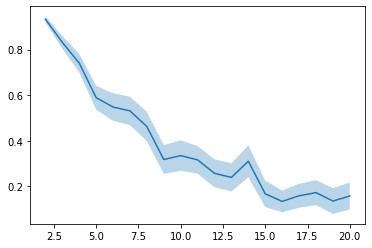

In [233]:
#_ = df.plot(x='x', y='p')
plt.plot(df['x'], df['p'])
plt.fill_between(x=df['x'], y1=df['p'] - 2 * df['sd'], y2=df['p'] + 2 * df['sd'], alpha=0.3)
plt.show()

## Models

### Logistic model

In [21]:
stan_logistic = pystan.StanModel(file='./logistic.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7fa4acbee23cf1b2cfe985c67ceeade8 NOW.


In [234]:
post_sample_logistic = stan_logistic.sampling(data=stan_data)

In [235]:
print(post_sample_logistic)

Inference for Stan model: anon_model_7fa4acbee23cf1b2cfe985c67ceeade8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      2.23  1.6e-3   0.06   2.13   2.19   2.23   2.27   2.35   1281    1.0
b     -0.26  1.8e-4 6.5e-3  -0.27  -0.26  -0.26  -0.25  -0.24   1325    1.0
lp__  -3021    0.03   0.97  -3023  -3021  -3020  -3020  -3020    973    1.0

Samples were drawn using NUTS at Sun Feb  9 14:03:56 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


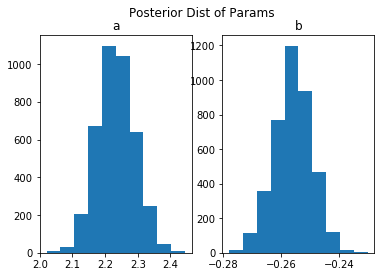

In [236]:
stanplot_postetior_hist(post_sample_logistic, ('a', 'b'))

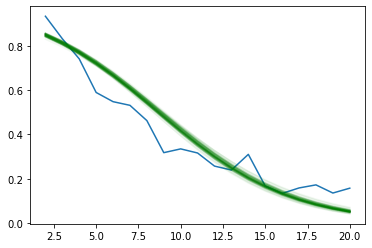

In [237]:
stanplot_posterior_lineplot(df['x'], df['p'], post_sample_logistic, ('a', 'b'), sigmoid_linear_curve)

### Simple triginometric model

In [62]:
stan_trig = pystan.StanModel(file='./trig.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7e1d147b382c4cc95d3dbdfff55ab083 NOW.


In [240]:
stan_data.update({'r': (1.68/2)/12, 'R': (4.25/2)/12})
post_sample_trig = stan_trig.sampling(data=stan_data_dict)

In [241]:
print(post_sample_trig)

Inference for Stan model: anon_model_7e1d147b382c4cc95d3dbdfff55ab083.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma           0.03  3.6e-5 1.4e-3   0.03   0.03   0.03   0.03   0.03   1551    1.0
p[1]            0.92  3.6e-4   0.01   0.89   0.91   0.92   0.93   0.94   1552    1.0
p[2]            0.75  5.4e-4   0.02   0.71   0.74   0.75   0.77   0.79   1552    1.0
p[3]            0.61  5.5e-4   0.02   0.57    0.6   0.61   0.63   0.66   1551    1.0
p[4]            0.51  5.0e-4   0.02   0.47    0.5   0.51   0.53   0.55   1551    1.0
p[5]            0.44  4.5e-4   0.02    0.4   0.42   0.44   0.45   0.47   1551    1.0
p[6]            0.38  4.0e-4   0.02   0.35   0.37   0.38   0.39   0.41   1551    1.0
p[7]            0.34  3.6e-4   0.01   0.31   0.33   0.34   0.35   0.36   1551    1.0
p[8]             0.3  3.3e-4   0.01   0.28   0

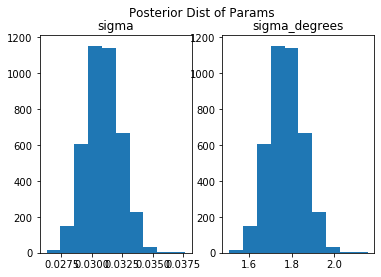

In [242]:
stanplot_postetior_hist(post_sample_trig, ('sigma', 'sigma_degrees'))

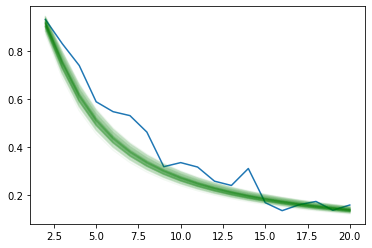

In [243]:
stanplot_posterior_lineplot(df['x'], df['p'], post_sample_trig, ('sigma'), trig_curve)

### Augmented trigonometric model

In [245]:
stan_overshot = pystan.StanModel(file='./trig_overshot.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_44be507e979734bbba2b844efdcc49cf NOW.


In [249]:
stan_data.update({'overshot': 1., 'distance_tolerance': 3.})
post_sample_overshot = stan_overshot.sampling(data=stan_data)

In [250]:
print(post_sample_overshot)

Inference for Stan model: anon_model_44be507e979734bbba2b844efdcc49cf.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma_angle      0.02  2.6e-5  1.3e-3   0.02   0.02   0.02   0.02   0.02   2640    1.0
sigma_distance   0.18  2.6e-4    0.01   0.15   0.17   0.17   0.18    0.2   2701    1.0
sigma_y          0.11  4.3e-4    0.02   0.07   0.09   0.11   0.13   0.17   3109    1.0
p_angle[1]       0.98  1.2e-4  6.0e-3   0.97   0.98   0.99   0.99   0.99   2713    1.0
p_angle[2]        0.9  4.0e-4    0.02   0.85   0.88    0.9   0.91   0.93   2662    1.0
p_angle[3]       0.78  5.4e-4    0.03   0.72   0.76   0.78    0.8   0.83   2628    1.0
p_angle[4]       0.67  5.7e-4    0.03   0.62   0.65   0.67   0.69   0.73   2609    1.0
p_angle[5]       0.58  5.5e-4    0.03   0.53   0.57   0.58    0.6   0.64   2598    1.0
p_angle[6]       0.52  5.2e-

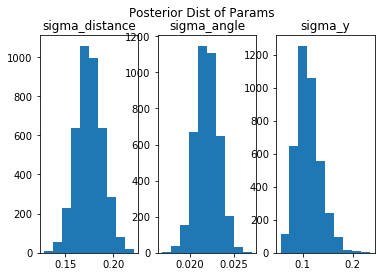

In [251]:
stanplot_postetior_hist(post_sample_overshot, ('sigma_distance', 'sigma_angle', 'sigma_y'))

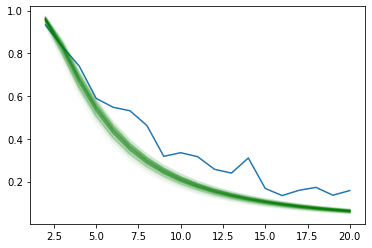

In [258]:
stanplot_posterior_lineplot(
    x=df['x'], 
    y=df['p'], 
    stan_sample=post_sample_overshot, 
    params=('sigma_distance', 'sigma_angle'), 
    f=overshot_curve
)